In [68]:
import seaborn as sns
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import seaborn as sns
from IPython.display import Image, display
from sklearn import metrics


sns.set_style("white")
sns.set_palette("husl")

class Config:
    #MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?(_epoch\d+)?")
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)(_epoch\d+)?")

    def __init__(self, filename):
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.epoch = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
        if groups[9]:
            unparsed_epoch = groups[8]
            self.epoch = int(unparsed_epoch.strip("_epoch"))


    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

    @property
    def label(self):
        print(self.strategy)
        if self.strategy == "topk":
            label = "{}, {}, top_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "lowk":
            label = "{}, {}, lowest_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "randomk":
            label = "{}, {}, random_{}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "kath":
            label = "{}, {}, {}/{}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, Min: {}".format(self.strategy,
                                                   self.network,
                                                   self.top_k) 
        elif self.strategy == "baseline":
            label = "{}, {}".format(self.strategy, self.network)    
        else:
            label = ""
        if self.trial:
            label += ", trial-{}".format(self.trial)
        if self.epoch:
            label += ", epoch-{}".format(self.epoch)
        return label

def write_file(plot_file_prefix):
    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    plt.clf()

def get_percentiles(d, num_percentiles):
    xs = np.arange(0, 100, 100./num_percentiles)
    ys = [np.percentile(d, x) for x in xs]
    return xs, ys
            

In [60]:
def plot_image_distributions(pickles_dir, plot_dir, trials=None, num_percentiles=100):
    print("In plot_image_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename)

        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        binwidth=1
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            
            # Plot histogram
            n, bins, patches = plt.hist(d.values(),
                                        bins=range(min(d.values()), max(d.values()) + binwidth, binwidth),
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)
            
            plt.title(config.label+" Num backprops: {}".format(sum(d.values())))
            plt.xlim(0, max(d.values()) + 1)
            plt.xlabel("Num backprops")
            plt.ylabel("Num images")
            subplot_dir = os.path.join(plot_dir, "images_dist")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix)
            
            # Plot percentiles
            plt.clf()
            xs, ys = get_percentiles(d.values(), num_percentiles)
            plt.plot(xs, ys)
            plt.title(config.label+" Num backprops: {}".format(sum(d.values())))
            plt.xlabel("Percentile")
            plt.ylabel("Num backprops per image")
            subplot_dir = os.path.join(plot_dir, "images_percentile")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix)

In [ ]:
def plot_confidence_distributions(pickles_dir, plot_dir, max_epoch=None, trials=None, num_percentiles=100):
    print("In plot_confidence_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        binwidth=1
        with open(pickles_file, 'rb') as handle:
            print(pickles_file)
            d = pickle.load(handle)
            for epoch, data in d.iteritems():
                if max_epoch is not None:
                    if epoch > max_epoch:
                        break
                
                # Plot histogram
                probs = [int(c*100) for c in data["confidences"]]
                num_backpropped = data["num_backpropped"]
                n, bins, patches = plt.hist(probs,
                                            bins=range(min(probs), max(probs) + binwidth, binwidth),
                                            normed=0,
                                            facecolor='green',
                                            alpha=0.75)
                plt.title("{}, {} backpropped".format(config.label, num_backpropped))
                plt.xlabel("Probability of target")
                plt.ylabel("Frequency")
                subplot_dir = os.path.join(plot_dir, "target_confidences")
                if not os.path.isdir(subplot_dir):
                    os.mkdir(subplot_dir)
                plot_prefix = os.path.join(subplot_dir, "{}_epoch{}_{}backpropped".format(filename,
                                                                              epoch,
                                                                              num_backpropped))
                          
                plt.tight_layout()
                write_file(plot_prefix)
                          
                # Plot percentiles
                plt.clf()
                xs, ys = get_percentiles(probs, num_percentiles)
                plt.plot(xs, ys)
                auc = metrics.auc(xs, ys)
                plt.title(config.label+" AUC: {}".format(auc))
                plt.xlabel("Percentile")
                plt.ylabel("Target confidence")
                subplot_dir = os.path.join(plot_dir, "target_confidences_percentiles")
                if not os.path.isdir(subplot_dir):
                    os.mkdir(subplot_dir)
                plt.tight_layout()
                plot_prefix = os.path.join(subplot_dir, "{}_epoch{}_{}backpropped".format(filename,
                                                                                          epoch,
                                                                                          num_backpropped))
                write_file(plot_prefix)

                # Wow, hack
                random_data_dir = os.path.join(subplot_dir, "data")
                if not os.path.isdir(random_data_dir):
                    os.mkdir(random_data_dir)
                extra_filename = "{}_epoch{}_{}backpropped.txt".format(filename,
                                                                       epoch,
                                                                       num_backpropped)
                print("Extra filename: {}".format(extra_filename))
                with open(extra_filename, "w+") as f:
                    for x, y in zip(xs, ys):
                        line = "{},{}\n".format(x, y)
                        f.write(line)
                                        


In [ ]:
def analyze_stdev(stdev_by_image_id, filename, src_dir="../data/images/cifar10_by_id", top_k=10):
    config = Config(filename)
    print("Analyzing stdevs for {}".format(config.label))
    stdevs = stdev_by_image_id.values()
    n, bins, patches = plt.hist(stdevs,
                                10,
                                normed=0,
                                alpha=0.8)            
    plt.title(config.label)
    plt.xlabel("Probability stdev")
    plt.ylabel("Frequency")

    subplot_dir = os.path.join(plot_dir, "probabilities_by_image")
    if not os.path.isdir(subplot_dir):
        os.mkdir(subplot_dir)
    plt.tight_layout()
    plot_prefix = os.path.join(subplot_dir, filename + "_stdev")
    write_file(plot_prefix)

    sorted_ids = sorted(stdev_by_image_id, key=lambda k: stdev_by_image_id[k])
    
    # Show image_ids with highest stdev
    print("Images from sample with highest stdev")
    for image_id in list(reversed(sorted_ids))[:top_k]:
        src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
        display(Image(filename=src_file))

    # Show image_ids with lowest stdev
    print("Images from sample with lowest stdev")
    for image_id in sorted_ids[:top_k]:
        src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
        display(Image(filename=src_file))
              

In [ ]:
def plot_probability_timelines(pickles_dir, plot_dir, max_ids=None, trials=None):
    print("In plot_probability_timelines for {}".format(plot_dir))
    palette = itertools.cycle(sns.color_palette())

    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            stdev_by_image_id = {}
            for image_id, ys in d.iteritems():
                xs = range(len(ys))
                stdev_by_image_id[image_id] = np.std(ys)
                if max_ids <= image_id:
                    break
                plt.plot(xs, ys, color=next(palette))
            plt.title(config.label)
            plt.xlabel("Epochs")
            plt.ylabel("Select Probability")

            subplot_dir = os.path.join(plot_dir, "probabilities_by_image")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plot_prefix = os.path.join(subplot_dir, filename)
            plt.tight_layout()
            write_file(plot_prefix)
            
           # analyze_standard_deviations
            analyze_stdev(stdev_by_image_id, filename)

In [ ]:
def plot_probability_distributions(pickles_dir, plot_dir, max_ids=None, trials=None):
    print("In plot_probability_timelines for {}".format(plot_dir))
    palette = itertools.cycle(sns.color_palette())

    for filename in os.listdir(pickles_dir):
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            probs = []
            for arr in d.values():
                probs.append(arr[-1])
            n, bins, patches = plt.hist(probs,
                                        50,
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)
            
            plt.title("{}, {} epochs".format(config.label, len(probs)))
            plt.xlabel("Select Probability")
            plt.ylabel("Distribution")
            plt.show()


In [70]:
def plot_experiment(experiment_dir,
                    plot_dir,
                    max_ids=0,
                    run_image_id_hist = False,
                    run_target_confidences = False,
                    run_probability_timelines = False,
                    run_probability_dist = False,
                    trials=None):
    pickles_dir = os.path.join(experiment_dir, "pickles")
    if os.path.isdir(pickles_dir):
        if run_probability_timelines:
            probabilities_dir = os.path.join(pickles_dir, "probabilities_by_image")
            if os.path.isdir(probabilities_dir):
                plot_probability_timelines(probabilities_dir,
                                           plot_dir,
                                           max_ids=max_ids,
                                           trials=trials)
        if run_target_confidences:
            target_confidences_dir = os.path.join(pickles_dir, "target_confidences")
            if os.path.isdir(target_confidences_dir):
                plot_confidence_distributions(target_confidences_dir, plot_dir, trials=trials)
        if run_image_id_hist:
            image_id_hist_dir = os.path.join(pickles_dir, "image_id_hist")
            if os.path.isdir(image_id_hist_dir):
                plot_image_distributions(image_id_hist_dir, plot_dir, trials=trials)
        if run_probability_dist:
            probability_dist_dir = os.path.join(pickles_dir, "probabilities_by_image")
            if os.path.isdir(probability_dist_dir):
                plot_probability_distributions(probability_dist_dir, plot_dir, trials=trials)
            

%matplotlib inline

In plot_probability_timelines for ../plots/batch_stats/181208_net/181208_net
deterministic
deterministic
Analyzing stdevs for deterministic, densenet, Min: 0.1, trial-1
deterministic
Images from sample with highest stdev


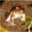

Images from sample with lowest stdev


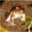

deterministic
deterministic
Analyzing stdevs for deterministic, densenet, Min: 1.0, trial-1
deterministic
Images from sample with highest stdev


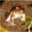

Images from sample with lowest stdev


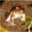

deterministic_cifar10
deterministic_cifar10
Analyzing stdevs for , trial-1
deterministic_cifar10
Images from sample with highest stdev


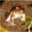

Images from sample with lowest stdev


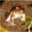

deterministic_cifar10
deterministic_cifar10
Analyzing stdevs for , trial-1
deterministic_cifar10
Images from sample with highest stdev


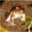

Images from sample with lowest stdev


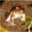

In plot_probability_timelines for ../plots/batch_stats/181208_net/181208_net
deterministic


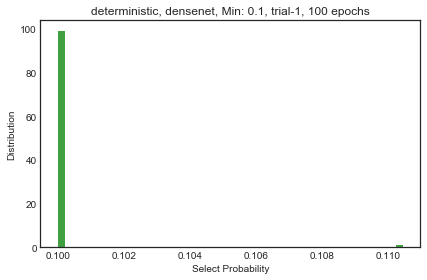

deterministic


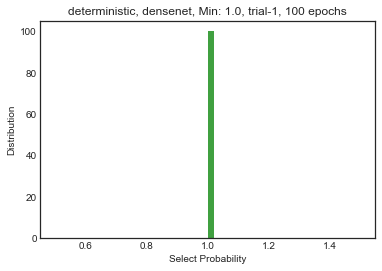

deterministic_cifar10


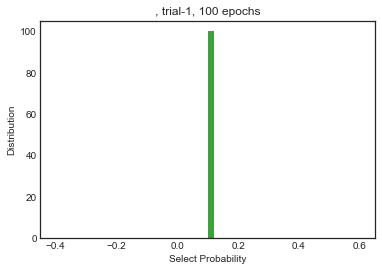

deterministic_cifar10


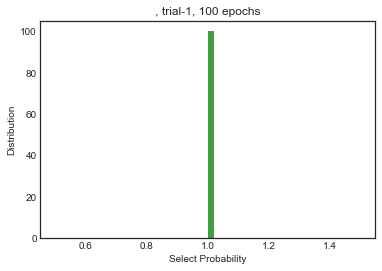

In plot_probability_timelines for ../plots/batch_stats/181208_net/181115_seedednew_aug
deterministic
deterministic
Analyzing stdevs for deterministic, resnet, Min: 0.1, trial-1
deterministic
Images from sample with highest stdev


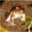

Images from sample with lowest stdev


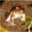

deterministic
deterministic
Analyzing stdevs for deterministic, resnet, Min: 1.0, trial-1
deterministic
Images from sample with highest stdev


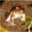

Images from sample with lowest stdev


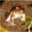

In plot_probability_timelines for ../plots/batch_stats/181208_net/181115_seedednew_aug
deterministic


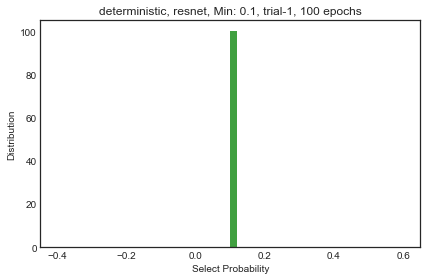

deterministic


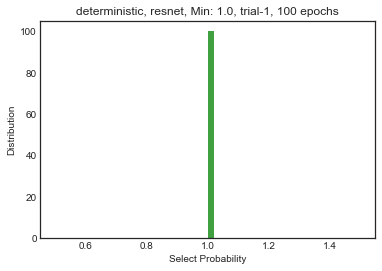

In [71]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181208_net"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181208_net", "181115_seedednew_aug"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir,
                    plot_dir,
                    max_ids=None,
                    trials=[1],
                    run_probability_timelines=True,
                    run_probability_dist=True)

In [33]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181213_params_nomin"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181213_params_nomin"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir, plot_dir, max_ids=100,
                    trials=[1])

In plot_images_percentile for ../plots/batch_stats/181213_params_nomin/181213_params_nomin
In plot_image_distributions for ../plots/batch_stats/181213_params_nomin/181213_params_nomin


<Figure size 432x288 with 0 Axes>

In [ ]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181219_baselr"
plot_home_dir += "/{}".format(experiment_batch_name)
if not os.path.exists(plot_home_dir):
    os.makedirs(plot_home_dir)

experiment_names = ["181219_baselr_kath"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/importance_sampling/{}/idxs".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_confidence_distributions(experiment_dir, plot_dir, max_epoch=None, trials=None)


In [14]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181212_topk"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181212_topk"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir, plot_dir, max_ids=100,
                    trials=[1])

In plot_image_distributions for ../plots/batch_stats/181212_topk/181212_topk


<Figure size 432x288 with 0 Axes>

In plot_probability_timelines for ../plots/batch_stats/181208_net/181208_net
deterministic
deterministic
Analyzing stdevs for deterministic, densenet, Min: 0.1, trial-1
deterministic
Images from sample with highest stdev


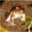

Images from sample with lowest stdev


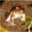

deterministic
deterministic
Analyzing stdevs for deterministic, densenet, Min: 1.0, trial-1
deterministic
Images from sample with highest stdev


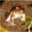

Images from sample with lowest stdev


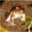

deterministic_cifar10
deterministic_cifar10
Analyzing stdevs for , trial-1
deterministic_cifar10
Images from sample with highest stdev


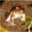

Images from sample with lowest stdev


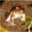

deterministic_cifar10
deterministic_cifar10
Analyzing stdevs for , trial-1
deterministic_cifar10
Images from sample with highest stdev


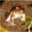

Images from sample with lowest stdev


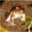

NameError: global name 'plot_probability_distribution' is not defined

<Figure size 432x288 with 0 Axes>

In [69]:
plot_home_dir = "../plots/batch_stats"

experiment_batch_name = "181208_net"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181208_net"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_experiment(experiment_dir, plot_dir, run_probability_timelines=True,
                    run_probability_dist=True)
